In [1]:
### importing libraries

from datetime import datetime,timedelta
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json
import os
import gc

from lightgbm import LGBMClassifier
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,accuracy_score,auc,classification_report

## load dataset

In [4]:
df1 = pd.read_csv('./data/sensing_data_1.csv')
df1.head()

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u17,2013-03-28 15:08:00,7712,372,64,105,6,6,10,295,...,2013,3,28,15,8,Thu,12,stress_ema,1,0
1,u17,2013-03-30 16:06:00,8090,103,0,28,10,9,19,456,...,2013,3,30,16,6,Sat,12,stress_ema,2,1
2,u17,2013-04-11 16:53:00,7808,362,15,78,7,6,8,372,...,2013,4,11,16,53,Thu,14,stress_ema,3,1
3,u17,2013-04-14 15:33:00,8181,117,0,29,6,6,6,895,...,2013,4,14,15,33,Sun,14,stress_ema,3,1
4,u17,2013-04-15 14:07:00,7413,572,83,158,15,14,22,608,...,2013,4,15,14,7,Mon,15,stress_ema,3,1


In [8]:
df1.columns,df1.columns[-10:]

(Index(['user_id', 'date_time', 'activity_inf_stationary_count',
        'activity_inf_walking_count', 'activity_inf_running_count',
        'activity_inf_unknown_count', 'app_usage_baseActivity_mClass',
        'app_usage_baseActivity_mPackage', 'app_usage_baseActivity_id_count',
        'app_usage_baseActivity_numActivities',
        'app_usage_baseActivity_numRunning', 'app_usage_topActivity_mClass',
        'app_usage_topActivity_mPackage', 'audio_inf_silence_count',
        'audio_inf_voice_count', 'audio_inf_noise_count',
        'audio_inf_unknown_count', 'conversation_hours', 'conversation_minutes',
        'dark_hours', 'dark_minutes', 'dark_seconds', 'phonecharge_hours',
        'phonecharge_minutes', 'phonecharge_seconds', 'phonelock_hours',
        'phonelock_minutes', 'phonelock_seconds', 'year', 'month', 'day',
        'hours', 'minute', 'weekday', 'weeknumber', 'label_source', 'rating',
        'stress_label'],
       dtype='object'),
 Index(['year', 'month', 'day', 'hou

In [9]:
df1 = df1.drop(df1.columns[-10:],axis=1)
df1.columns

Index(['user_id', 'date_time', 'activity_inf_stationary_count',
       'activity_inf_walking_count', 'activity_inf_running_count',
       'activity_inf_unknown_count', 'app_usage_baseActivity_mClass',
       'app_usage_baseActivity_mPackage', 'app_usage_baseActivity_id_count',
       'app_usage_baseActivity_numActivities',
       'app_usage_baseActivity_numRunning', 'app_usage_topActivity_mClass',
       'app_usage_topActivity_mPackage', 'audio_inf_silence_count',
       'audio_inf_voice_count', 'audio_inf_noise_count',
       'audio_inf_unknown_count', 'conversation_hours', 'conversation_minutes',
       'dark_hours', 'dark_minutes', 'dark_seconds', 'phonecharge_hours',
       'phonecharge_minutes', 'phonecharge_seconds', 'phonelock_hours',
       'phonelock_minutes', 'phonelock_seconds'],
      dtype='object')

In [5]:
df2 = pd.read_csv('./data/ema_data_1.csv')
df2.head()

,user_id,date_time,number_Social,experience_Class_neutral,experience_Class_st_agree,experience_Class_agree,experience_Class_disagree,experience_Class_st_disagree,due_Class_yes,due_Class_no,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
0,u22,2013-03-27 00:35:00,0,0,0,0,0,0,0,0,...,2013,3,27,0,35,Wed,12,stress_ema,1,0
1,u22,2013-03-27 15:03:00,2,1,0,0,0,0,0,1,...,2013,3,27,15,3,Wed,12,stress_ema,1,0
2,u22,2013-03-27 20:06:00,2,2,0,1,0,0,0,3,...,2013,3,27,20,6,Wed,12,stress_ema,4,0
3,u22,2013-03-28 00:20:00,22,2,0,1,0,0,0,3,...,2013,3,28,0,20,Thu,12,stress_ema,5,0
4,u22,2013-03-28 03:00:00,32,2,0,1,0,0,0,3,...,2013,3,28,3,0,Thu,12,stress_ema,5,0


In [10]:
df = df1.merge(df2,on=['user_id','date_time'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455 entries, 0 to 2454
Data columns (total 92 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   user_id                               2455 non-null   object
 1   date_time                             2455 non-null   object
 2   activity_inf_stationary_count         2455 non-null   int64 
 3   activity_inf_walking_count            2455 non-null   int64 
 4   activity_inf_running_count            2455 non-null   int64 
 5   activity_inf_unknown_count            2455 non-null   int64 
 6   app_usage_baseActivity_mClass         2455 non-null   int64 
 7   app_usage_baseActivity_mPackage       2455 non-null   int64 
 8   app_usage_baseActivity_id_count       2455 non-null   int64 
 9   app_usage_baseActivity_numActivities  2455 non-null   int64 
 10  app_usage_baseActivity_numRunning     2455 non-null   int64 
 11  app_usage_topActivity_mClass  

In [12]:
df.describe()

,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,...,grade_C,grade_C_min,year,month,day,hours,minute,weeknumber,rating,stress_label
count,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,...,2455.0,2455.0,2455.0,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000,2455.000000
mean,8761.414257,513.306721,127.201222,338.782892,16.164155,14.663544,21.452546,1170.241548,675.301426,19.388187,...,0.0,0.0,2013.0,4.224847,15.397963,14.274134,24.409369,15.600815,2.182077,0.291650
std,6958.299961,765.212702,214.582839,664.912629,9.526971,8.406010,12.847520,1253.679425,470.465766,11.392549,...,0.0,0.0,0.0,0.664591,9.455342,6.510618,18.665454,2.711081,1.294401,0.454614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,2013.0,3.000000,1.000000,0.000000,0.000000,12.000000,1.000000,0.000000
25%,6984.500000,179.000000,6.000000,56.000000,10.000000,9.000000,12.000000,440.000000,285.000000,12.000000,...,0.0,0.0,2013.0,4.000000,7.000000,11.000000,7.000000,13.000000,1.000000,0.000000
50%,7574.000000,317.000000,51.000000,115.000000,15.000000,14.000000,20.000000,863.000000,584.000000,18.000000,...,0.0,0.0,2013.0,4.000000,15.000000,15.000000,22.000000,15.000000,2.000000,0.000000
75%,7916.500000,488.000000,156.000000,266.000000,21.000000,19.000000,28.000000,1422.000000,997.000000,26.000000,...,0.0,0.0,2013.0,5.000000,25.000000,19.000000,40.000000,18.000000,3.000000,1.000000
max,38597.000000,7505.000000,3933.000000,6825.000000,68.000000,60.000000,117.000000,9325.000000,3752.000000,85.000000,...,0.0,0.0,2013.0,6.000000,31.000000,23.000000,59.000000,22.000000,5.000000,1.000000


## Dropping columns

In [13]:
df = df.sample(frac= 1,random_state=2022)
df

,user_id,date_time,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,...,year,month,day,hours,minute,weekday,weeknumber,label_source,rating,stress_label
2391,u33,2013-04-04 23:42:00,7679,359,71,61,47,43,47,8703,...,2013,4,4,23,42,Thu,13,stress_ema,1,0
1383,u27,2013-04-15 21:00:00,7689,230,1,193,12,11,36,779,...,2013,4,15,21,0,Mon,15,stress_ema,1,0
962,u41,2013-04-08 22:47:00,1589,1,0,2,3,3,3,70,...,2013,4,8,22,47,Mon,14,stress_ema,1,0
1063,u39,2013-04-16 23:34:00,8079,83,13,104,6,6,9,312,...,2013,4,16,23,34,Tue,15,stress_ema,1,0
2292,u49,2013-05-16 19:11:00,14590,660,92,86,23,20,25,1394,...,2013,5,16,19,11,Thu,19,stress_ema,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,u08,2013-03-26 19:04:00,0,0,0,0,13,11,20,465,...,2013,3,26,19,4,Tue,12,stress_ema,2,1
624,u36,2013-04-17 01:55:00,7565,330,128,168,15,13,17,880,...,2013,4,17,1,55,Wed,15,stress_ema,2,1
173,u51,2013-04-30 17:06:00,7966,179,118,13,6,6,9,348,...,2013,4,30,17,6,Tue,17,stress_ema,3,1
1244,u10,2013-04-08 21:04:00,7680,356,46,60,9,9,11,842,...,2013,4,8,21,4,Mon,14,stress_ema,5,0


In [14]:
df = df.drop(['user_id','date_time','year','label_source','rating'],axis=1)

df['stress_label'].value_counts()

0    1739
1     716
Name: stress_label, dtype: int64

In [15]:
df['weekday'].value_counts()

Wed    392
Tue    385
Thu    375
Fri    373
Mon    362
Sun    330
Sat    238
Name: weekday, dtype: int64

In [16]:
weekday_map = {"Sat":0,"Sun":1,"Mon":2,"Tue":3,"Wed":4,"Thu":5,"Fri":6}

df['weekday'] = df['weekday'].map(weekday_map)

df['weekday'].value_counts()

4    392
3    385
5    375
6    373
2    362
1    330
0    238
Name: weekday, dtype: int64

In [17]:
df = df.reset_index(drop=True)
df

,activity_inf_stationary_count,activity_inf_walking_count,activity_inf_running_count,activity_inf_unknown_count,app_usage_baseActivity_mClass,app_usage_baseActivity_mPackage,app_usage_baseActivity_id_count,app_usage_baseActivity_numActivities,app_usage_baseActivity_numRunning,app_usage_topActivity_mClass,...,grade_C_plu,grade_C,grade_C_min,month,day,hours,minute,weekday,weeknumber,stress_label
0,7679,359,71,61,47,43,47,8703,1863,53,...,0,0,0,4,4,23,42,5,13,0
1,7689,230,1,193,12,11,36,779,741,16,...,0,0,0,4,15,21,0,2,15,0
2,1589,1,0,2,3,3,3,70,66,5,...,0,0,0,4,8,22,47,2,14,0
3,8079,83,13,104,6,6,9,312,312,6,...,0,0,0,4,16,23,34,3,15,0
4,14590,660,92,86,23,20,25,1394,1240,23,...,0,0,0,5,16,19,11,5,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2450,0,0,0,0,13,11,20,465,423,14,...,0,0,0,3,26,19,4,3,12,1
2451,7565,330,128,168,15,13,17,880,806,18,...,0,0,0,4,17,1,55,4,15,1
2452,7966,179,118,13,6,6,9,348,348,6,...,0,0,0,4,30,17,6,3,17,1
2453,7680,356,46,60,9,9,11,842,801,11,...,0,0,0,4,8,21,4,2,14,0


## Train val split

In [18]:
df_train,df_val,df_test = df[:(len(df)*3)//5],df[(len(df)*3)//5:(len(df)*4)//5],df[(len(df)*4)//5:]

len(df_train),len(df_val),len(df_test)

(1473, 491, 491)

In [19]:
df_train[df_train.columns[-1]]

0       0
1       0
2       0
3       0
4       0
       ..
1468    0
1469    0
1470    0
1471    0
1472    0
Name: stress_label, Length: 1473, dtype: int64

## LGBM

In [27]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]

In [20]:
def objective(trial):
  n_estimators_hp = trial.suggest_int('n_estimators', 50, 1000)
  max_depth_hp =  trial.suggest_int('max_depth', 10, 500)
  min_child_samples_hp = trial.suggest_int('min_child_samples', 10, 100)
  num_leaves_hp = trial.suggest_int('num_leaves', 2, 256)
  learning_rate_hp = trial.suggest_loguniform('learning_rate',1e-5,10)
  
  model = LGBMClassifier(n_estimators = n_estimators_hp, 
                         max_depth = max_depth_hp, 
                         min_child_samples = min_child_samples_hp,
                         num_leaves = num_leaves_hp,
                         learning_rate = learning_rate_hp,
                         random_state = 0,is_unbalance=True)
  
  model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
  
  pred_probs = model.predict_proba(df_val[df_val.columns[:-1]])
  
  return roc_auc_score(df_val[df_val.columns[-1]], pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 13:06:59,497] A new study created in memory with name: no-name-4898833e-9c46-4e2d-a38b-63561724ed9b
/tmp/ipykernel_2472196/3744688316.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate_hp = trial.suggest_loguniform('learning_rate',1e-5,10)
[I 2022-11-25 13:07:00,115] Trial 0 finished with value: 0.7512207813000321 and parameters: {'n_estimators': 397, 'max_depth': 323, 'min_child_samples': 70, 'num_leaves': 83, 'learning_rate': 0.22731448533331325}. Best is trial 0 with value: 0.7512207813000321.
/tmp/ipykernel_2472196/3744688316.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate_hp = trial.suggest_lo

In [21]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))


# Best trial: {'n_estimators': 852, 'max_depth': 227, 'min_child_samples': 26, 'num_leaves': 240, 'learning_rate': 0.08784233555425727}
#   Value: 0.7731748318924112

Best trial: {'n_estimators': 852, 'max_depth': 227, 'min_child_samples': 26, 'num_leaves': 240, 'learning_rate': 0.08784233555425727}
  Value: 0.7731748318924112


In [22]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = LGBMClassifier(**{'n_estimators': 852, 'max_depth': 227, 'min_child_samples': 26, 'num_leaves': 240, 'learning_rate': 0.08784233555425727}, random_state = 0,is_unbalance=True )
 
model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
 
roc_auc_score(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])

0.755056179775281

In [23]:
fpr, tpr, _ = roc_curve(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])
roc_auc = auc(fpr, tpr)

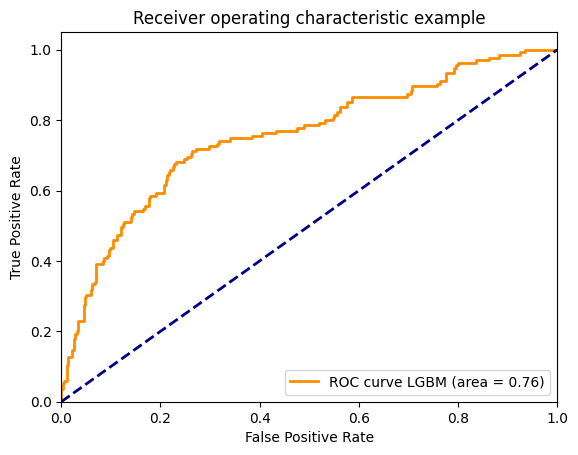

In [24]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve LGBM (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [25]:
print(classification_report(df_test[df_test.columns[-1]], model.predict(df_test[df_test.columns[:-1]])))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       356
           1       0.60      0.50      0.55       135

    accuracy                           0.77       491
   macro avg       0.71      0.69      0.70       491
weighted avg       0.76      0.77      0.77       491



In [28]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train_x.columns),reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,1735,minute
1,1577,audio_inf_silence_count
2,1475,activity_inf_stationary_count
3,1470,activity_inf_unknown_count
4,1405,activity_inf_running_count
...,...,...
81,0,experience_Class_st_disagree
82,0,effort_Class 2 yes
83,0,effort_Class 2 no
84,0,challenge_Class 2 no


## Log reg

In [29]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]


df_train_x.shape,df_train_y.shape,df_val_x.shape,df_val_y.shape,df_test_x.shape,df_test_y.shape

((1473, 86), (1473,), (491, 86), (491,), (491, 86), (491,))

In [30]:
sc = StandardScaler()
sc = sc.fit(df_train_x)

df_train_x_sc = sc.transform(df_train_x)
df_val_x_sc = sc.transform(df_val_x)
df_test_x_sc = sc.transform(df_test_x)

In [45]:
def objective(trial):
  c_hp = trial.suggest_float('C', 0.0001, 100)
  
  
  model = LogisticRegression(C = c_hp, 
                         
                         random_state = 0,class_weight="balanced",n_jobs = -1)
  
  model.fit(df_train_x_sc, df_train_y)
  
  pred_probs = model.predict_proba(df_val_x_sc)
  
  return roc_auc_score(df_val_y, pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 13:14:52,510] A new study created in memory with name: no-name-c660a029-2cc2-4ca9-8995-a5811fdadd2b
[I 2022-11-25 13:14:52,544] Trial 0 finished with value: 0.6875600384245918 and parameters: {'C': 11.47129226837773}. Best is trial 0 with value: 0.6875600384245918.
[I 2022-11-25 13:14:52,590] Trial 1 finished with value: 0.687339897534422 and parameters: {'C': 21.401588278300967}. Best is trial 0 with value: 0.6875600384245918.
[I 2022-11-25 13:14:52,624] Trial 2 finished with value: 0.6868996157540826 and parameters: {'C': 44.005116431721746}. Best is trial 0 with value: 0.6875600384245918.
[I 2022-11-25 13:14:52,691] Trial 3 finished with value: 0.6869596541786743 and parameters: {'C': 60.7529476403844}. Best is trial 0 with value: 0.6875600384245918.
[I 2022-11-25 13:14:52,726] Trial 4 finished with value: 0.6872398334934358 and parameters: {'C': 77.1012027709482}. Best is trial 0 with value: 0.6875600384245918.
[I 2022-11-25 13:14:52,769] Trial 5 finished with value: 

In [46]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'C': 10.952157568153051}
#   Value: 0.6878402177393531

Best trial: {'C': 10.952157568153051}
  Value: 0.6878402177393531


In [47]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = LogisticRegression(**{'C': 10.952157568153051}, random_state = 0,class_weight="balanced",n_jobs = -1)
 
model.fit(df_train_x_sc, df_train_y)
 
roc_auc_score(df_test_y, model.predict_proba(df_test_x_sc)[:,1])

0.7082188930503537

In [48]:
fpr, tpr, _ = roc_curve(df_test_y, model.predict_proba(df_test_x_sc)[:,1])
roc_auc = auc(fpr, tpr)

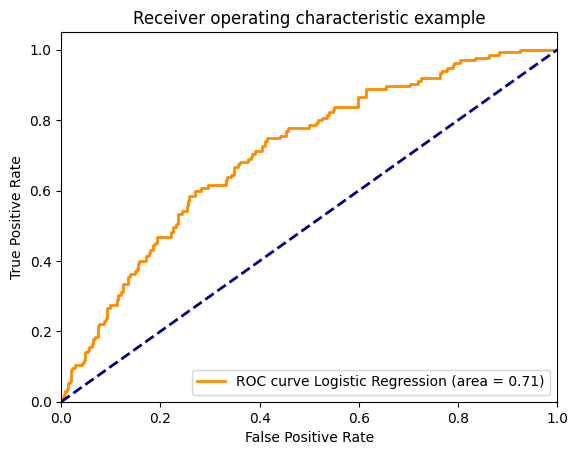

In [49]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Logistic Regression (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [50]:
print(classification_report(df_test_y, model.predict(df_test_x_sc)))

              precision    recall  f1-score   support

           0       0.85      0.60      0.70       356
           1       0.41      0.71      0.52       135

    accuracy                           0.63       491
   macro avg       0.63      0.66      0.61       491
weighted avg       0.73      0.63      0.65       491



## SVM

In [37]:
def objective(trial):
  c_hp = trial.suggest_float('C', 0.001, 100)
  
  
  model = SVC(C = c_hp, 
                         
                         random_state = 0,class_weight="balanced",probability = True)
  
  model.fit(df_train_x_sc, df_train_y)
  
  pred_probs = model.predict_proba(df_val_x_sc)
  
  return roc_auc_score(df_val_y, pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 13:12:39,166] A new study created in memory with name: no-name-bb7d200b-d03b-408a-a8a4-947e4452867c
[I 2022-11-25 13:12:39,548] Trial 0 finished with value: 0.7183397374319566 and parameters: {'C': 3.1351021659427523}. Best is trial 0 with value: 0.7183397374319566.
[I 2022-11-25 13:12:40,011] Trial 1 finished with value: 0.693473823246878 and parameters: {'C': 46.75221176191729}. Best is trial 0 with value: 0.7183397374319566.
[I 2022-11-25 13:12:40,489] Trial 2 finished with value: 0.6897414345180914 and parameters: {'C': 63.869462234176524}. Best is trial 0 with value: 0.7183397374319566.
[I 2022-11-25 13:12:40,983] Trial 3 finished with value: 0.6915225744476466 and parameters: {'C': 57.28553361120225}. Best is trial 0 with value: 0.7183397374319566.
[I 2022-11-25 13:12:41,462] Trial 4 finished with value: 0.684257925072046 and parameters: {'C': 89.95268836045861}. Best is trial 0 with value: 0.7183397374319566.
[I 2022-11-25 13:12:41,892] Trial 5 finished with value:

In [40]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'C': 2.6671536229928803}
#   Value: 0.7192803394172271

Best trial: {'C': 2.6671536229928803}
  Value: 0.7192803394172271


In [41]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = SVC(**{'C': 2.6671536229928803}, random_state = 0,class_weight="balanced",probability = True)
 
model.fit(df_train_x_sc, df_train_y)
 
roc_auc_score(df_test_y, model.predict_proba(df_test_x_sc)[:,1])

0.6816687473990846

In [42]:
fpr, tpr, _ = roc_curve(df_test_y, model.predict_proba(df_test_x_sc)[:,1])
roc_auc = auc(fpr, tpr)

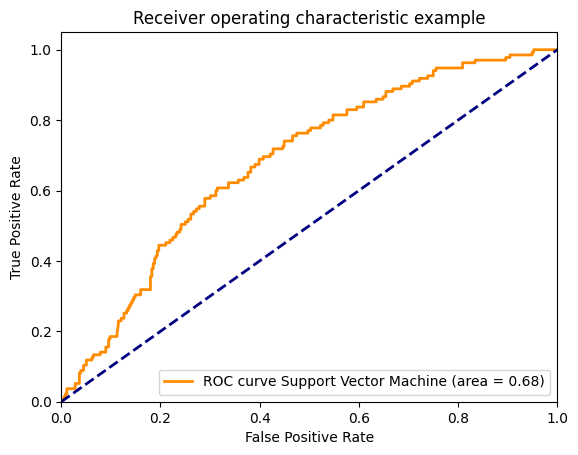

In [43]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Support Vector Machine (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [44]:
print(classification_report(df_test_y, model.predict(df_test_x_sc)))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       356
           1       0.41      0.61      0.49       135

    accuracy                           0.65       491
   macro avg       0.61      0.64      0.61       491
weighted avg       0.70      0.65      0.66       491



## Random forest

In [51]:
df_train_x,df_train_y = df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]]
df_val_x,df_val_y = df_val[df_val.columns[:-1]], df_val[df_val.columns[-1]]
df_test_x,df_test_y = df_test[df_test.columns[:-1]], df_test[df_test.columns[-1]]


df_train_x.shape,df_train_y.shape,df_val_x.shape,df_val_y.shape,df_test_x.shape,df_test_y.shape

((1473, 86), (1473,), (491, 86), (491,), (491, 86), (491,))

In [52]:
def objective(trial):
  n_estimators_hp = trial.suggest_int('n_estimators', 50, 1000)
  max_depth_hp =  trial.suggest_int('max_depth', 10, 100)
  min_child_samples_hp = trial.suggest_int('min_samples_split', 10, 100)
  num_leaves_hp = trial.suggest_int('min_samples_leaf', 2, 256)
  
  
  model = RandomForestClassifier(n_estimators = n_estimators_hp, 
                         max_depth = max_depth_hp, 
                         min_samples_split = min_child_samples_hp,
                         min_samples_leaf = num_leaves_hp,
                         
                         random_state = 0,class_weight="balanced",n_jobs = -1)
  
  model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
  
  pred_probs = model.predict_proba(df_val[df_val.columns[:-1]])
  
  return roc_auc_score(df_val[df_val.columns[-1]], pred_probs[:,1])
  #return precision_score(y_test, y_pred)
 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-11-25 13:16:19,841] A new study created in memory with name: no-name-ac7402b3-48ca-486b-a410-5a5167628cec
[I 2022-11-25 13:16:22,397] Trial 0 finished with value: 0.671910022414345 and parameters: {'n_estimators': 756, 'max_depth': 34, 'min_samples_split': 24, 'min_samples_leaf': 134}. Best is trial 0 with value: 0.671910022414345.
[I 2022-11-25 13:16:25,289] Trial 1 finished with value: 0.666046269612552 and parameters: {'n_estimators': 805, 'max_depth': 16, 'min_samples_split': 97, 'min_samples_leaf': 192}. Best is trial 0 with value: 0.671910022414345.
[I 2022-11-25 13:16:25,607] Trial 2 finished with value: 0.6617435158501442 and parameters: {'n_estimators': 213, 'max_depth': 72, 'min_samples_split': 34, 'min_samples_leaf': 247}. Best is trial 0 with value: 0.671910022414345.
[I 2022-11-25 13:16:27,553] Trial 3 finished with value: 0.6729907140569965 and parameters: {'n_estimators': 622, 'max_depth': 57, 'min_samples_split': 77, 'min_samples_leaf': 129}. Best is trial 3 wit

In [52]:
print('Best trial:', study.best_trial.params)
trial = study.best_trial
print("  Value: {}".format(trial.value))

# Best trial: {'n_estimators': 836, 'max_depth': 34, 'min_samples_split': 17, 'min_samples_leaf': 5}
#   Value: 0.7398434998398975

Best trial: {'n_estimators': 836, 'max_depth': 34, 'min_samples_split': 17, 'min_samples_leaf': 5}
  Value: 0.7398434998398975


In [59]:
# model = LGBMClassifier(**study.best_trial.params, random_state = 0,is_unbalance=True )

model = RandomForestClassifier(**{'n_estimators': 836, 'max_depth': 34, 'min_samples_split': 17, 'min_samples_leaf': 5},random_state = 0 ,class_weight="balanced",n_jobs = -1)
 
model.fit(df_train[df_train.columns[:-1]], df_train[df_train.columns[-1]])
 
roc_auc_score(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])

0.7196004993757803

In [60]:
fpr, tpr, _ = roc_curve(df_test[df_test.columns[-1]], model.predict_proba(df_test[df_test.columns[:-1]])[:,1])
roc_auc = auc(fpr, tpr)

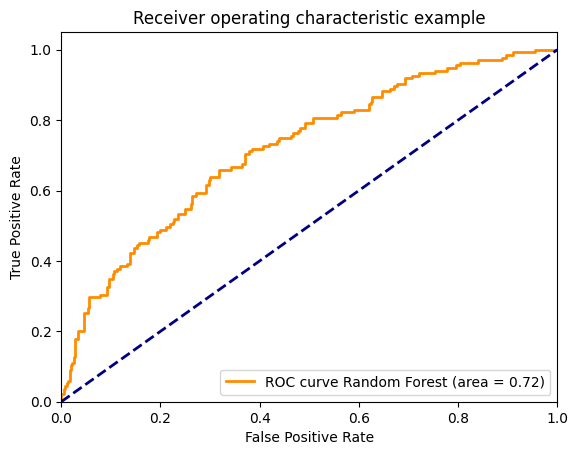

In [61]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve Random Forest (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [62]:
print(classification_report(df_test[df_test.columns[-1]], model.predict(df_test[df_test.columns[:-1]])))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       356
           1       0.52      0.45      0.48       135

    accuracy                           0.73       491
   macro avg       0.66      0.65      0.65       491
weighted avg       0.72      0.73      0.73       491



In [63]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_train_x.columns),reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,0.052970,activity_inf_unknown_count
1,0.047634,activity_inf_stationary_count
2,0.044831,day
3,0.043263,weeknumber
4,0.039971,audio_inf_silence_count
...,...,...
81,0.000000,grade_B_min
82,0.000000,grade_B
83,0.000000,effort_Class 2 no
84,0.000000,challenge_Class 2 no


## End